# Assignment 2: Word Prediction

**Deadline**: Sunday, December 11th, by 8pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

 

In this assignment, we will make a neural network that can predict the next word
in a sentence given the previous three.  
In doing this prediction task, our neural networks will learn about *words* and about
how to represent words. We'll explore the *vector representations* of words that our
model produces, and analyze these representations.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that you properly explain what you are doing and why.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data (18%)

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`raw_sentences.txt` from the course page on Moodle and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Find the path to `raw_sentences.txt`:

In [3]:
file_path = '/content/gdrive/My Drive/raw_sentences.txt' # TODO - UPDATE ME!

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [4]:
sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [5]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use `10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [6]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

### Part (a) -- 3%

**Display** 10 sentences in the training set.
**Explain** how punctuations are treated in our word representation, and how words
with apostrophes are represented.

In [7]:
# Your code goes here
for s in train[0:10]:
  print(s )


['last', 'night', ',', 'he', 'said', ',', 'did', 'it', 'for', 'me', '.']
['on', 'what', 'can', 'i', 'do', '?']
['now', 'where', 'does', 'it', 'go', '?']
['what', 'did', 'the', 'court', 'do', '?']
['but', 'at', 'the', 'same', 'time', ',', 'we', 'have', 'a', 'long', 'way', 'to', 'go', '.']
['that', 'was', 'the', 'only', 'way', '.']
['this', 'team', 'will', 'be', 'back', '.']
['so', 'that', 'is', 'what', 'i', 'do', '.']
['we', 'have', 'a', 'right', 'to', 'know', '.']
['now', 'they', 'are', 'three', '.']


**Write your answers here:**

Punctuations, and also words with apostrophes, are treated as normal words in our representation.

### Part (b) -- 4%

**Print** the 10 most common words in the vocabulary and how often does each of these
words appear in the training sentences. Express the second quantity as a percentage
(i.e. number of occurences of the  word / total number of words in the training set).

These are useful quantities to compute, because one of the first things a machine learning model will learn is to predict the **most common** class. Getting a sense of the
distribution of our data will help you understand our model's behaviour.

You can use Python's `collections.Counter` class if you would like to.

In [8]:
# Your code goes here
from collections import Counter

train_vocab = [w for s in train for w in s]
c = Counter(train_vocab)


In [9]:
most_common = c.most_common()[0:9]
N = len(train_vocab)

for w in most_common:
  print(f'The word " {w[0]} " appears {round(100* w[1]/N,2)}% of the time')

The word " . " appears 10.7% of the time
The word " it " appears 3.85% of the time
The word " , " appears 3.25% of the time
The word " i " appears 2.94% of the time
The word " do " appears 2.69% of the time
The word " to " appears 2.58% of the time
The word " nt " appears 2.16% of the time
The word " ? " appears 2.14% of the time
The word " the " appears 2.09% of the time


### Part (c) -- 11%

Our neural network will take as input three words and predict the next one. Therefore, we need our data set to be comprised of seuqnces of four consecutive words in a sentence, referred to as *4grams*. 

**Complete** the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a 
list of sentences (i.e. list of list of words), and generate an 
$N \times 4$ numpy matrix containing indices of 4 words that appear
next to each other, where $N$ is the number of 4grams (sequences of 4 words appearing one after the other) that can be found in the complete list of sentences. Examples of how these functions should operate are detailed in the code below. 

You can use the defined `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [10]:
# A list of all the words in the data set. We will assign a unique 

# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))

# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))

# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'], ['other', 'one', 'since', 'yesterday'], ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """

   # Write your code here
    indices = [ [vocab_stoi[w] for w in s]  for s in sents ]
    return indices
    
   

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """
    lst_4grams = []
    for s in seqs:
      for i in range(len(s)-3):
        lst_4grams.append(s [i:i+4])

    return lst_4grams
    # Write your code here

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

# We can now generate our data which will be used to train and test the network
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

In [11]:
convert_words_to_indices([['one','only']])

[[148, 149]]

In [12]:
print(f'1st sentence' ,generate_4grams([['12','132','149','206','15']]))
print(f'2nd sentence' ,generate_4grams([['123','33','45']]))
print(f'3rd sentence' ,generate_4grams([['144','134','67','85','11','88']]))


1st sentence [['12', '132', '149', '206'], ['132', '149', '206', '15']]
2nd sentence []
3rd sentence [['144', '134', '67', '85'], ['134', '67', '85', '11'], ['67', '85', '11', '88']]


## Question 2. A Multi-Layer Perceptron (44%)

In this section, we will build a two-layer multi-layer perceptron. 
Our model will look like this:

<img src="https://drive.google.com/uc?id=15uMLB-YsMHSOr0EQfTRhWd4o9enIOjUe">

Since the sentences in the data are comprised of $250$ distinct words, our task boils down to claissfication where the label space $\mathcal{S}$ is of cardinality $|\mathcal{S}|=250$ while our input, which is comprised of a combination of three words, is treated as a vector of size $750\times 1$ (i.e., the concatanation of three one-hot $250\times 1$ vectors).

The following function `get_batch` will take as input the whole dataset and output a single batch for the training. The output size of the batch is explained below.

**Implement** yourself a function `make_onehot` which takes the data in index notation and output it in a onehot notation.

Start by reviewing the helper function, which is given to you:

In [13]:
def make_onehot(data):
    """
    Convert one batch of data in the index notation into its corresponding onehot
    notation. Remember, the function should work for both xt and st. 
     
    input - vector with shape D (1D or 2D)
    output - vector with shape (D,250)
    """


    
    # return the 1hot representation by selecting the corresponding
    # row in the Identity matrix for each data element
    return np.eye(250)[data]

    # Write your code here

def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xt, st) where:
     - `xt` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `st` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_mind
    """
    xt = data[range_min:range_max, :3]
    xt = make_onehot(xt)
    st = data[range_min:range_max, 3]
    if onehot:
        st = make_onehot(st).reshape(-1, 250)
    return xt, st


### Part (a) -- 8%

We build the model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. 

**Complete** the `forward` function below:

In [14]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_hidden=400):
        super(PyTorchMLP, self).__init__()
        self.layer1 = nn.Linear(750, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden

    def forward(self, inp):
        inp = inp.reshape([-1, 750])
        hiddenLayer = self.layer1(inp)
        return self.layer2(hiddenLayer)
        # TODO: complete this function 
        # Note that we will be using the 
        #nn.CrossEntropyLoss(), which computes the softmax operation internally,
        # as loss criterion

### Part (b) -- 10%

We next  train the PyTorch model using the Adam optimizer and the cross entropy loss.

**Complete** the function `run_pytorch_gradient_descent`, and use it to train your PyTorch MLP model.

**Obtain** a training accuracy of at least 35% while changing only the hyperparameters of the train function.

Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.

In [15]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xt, st = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        y = model(torch.Tensor(xt))
        y = y.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(y, axis=1)
        correct += np.sum(pred == st)
        N += st.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xt, st = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xt = torch.Tensor(xt)
            st = torch.Tensor(st).long()

            zs = model.forward(xt)                      # compute prediction logit
            loss = criterion(zs, st)                    # compute the total loss

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            loss.backward()                             # compute updates for each parameter
            optimizer.step()                            # make the updates for each parameter
            optimizer.zero_grad()                       # a clean up step for PyTorch

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [16]:
# This loop is going through a large range of Hyperparameters
# and plots any considerable learning curve ending with more than 35% acc
# announcing the hyperparameters used to reach that
# This way we chose the best hyperparameters considering the learning curves and the final results.
"""
for batch_size in range(100,2000,300):
  for L_rate_expo in range(-8, -14, -1):
    pytorch_mlp = PyTorchMLP()
    learning_rate = 2**(L_rate_expo)
    
    print('Hyperparameters for this try:')
    print(f'Batch size = {batch_size}')
    print(f'Learning rate = {learning_rate}')
    learning_curve_info = run_pytorch_gradient_descent(pytorch_mlp, train4grams, valid4grams,
                                                      batch_size, learning_rate, weight_decay=0, max_iters = 1500,
                                                      checkpoint_path=None)
    if learning_curve_info[3][np.size(learning_curve_info[3])-1] > 0.35:
      plot_learning_curve(*learning_curve_info)
      print('Hyperparameters that made it to 35% acc (train set):')
      print(f'Batch size = {batch_size}')
      print(f'Learning rate = {learning_rate}')
"""

"\nfor batch_size in range(100,2000,300):\n  for L_rate_expo in range(-8, -14, -1):\n    pytorch_mlp = PyTorchMLP()\n    learning_rate = 2**(L_rate_expo)\n    \n    print('Hyperparameters for this try:')\n    print(f'Batch size = {batch_size}')\n    print(f'Learning rate = {learning_rate}')\n    learning_curve_info = run_pytorch_gradient_descent(pytorch_mlp, train4grams, valid4grams,\n                                                      batch_size, learning_rate, weight_decay=0, max_iters = 1500,\n                                                      checkpoint_path=None)\n    if learning_curve_info[3][np.size(learning_curve_info[3])-1] > 0.35:\n      plot_learning_curve(*learning_curve_info)\n      print('Hyperparameters that made it to 35% acc (train set):')\n      print(f'Batch size = {batch_size}')\n      print(f'Learning rate = {learning_rate}')\n"

Considering the learning curves of using batch size of 1300, with learning rate of 0.002, we chose these hyperparameters for our model.


Iter 0. [Val Acc 3%] [Train Acc 3%, Loss 5.523611]
Iter 500. [Val Acc 34%] [Train Acc 35%, Loss 2.733508]
Iter 1000. [Val Acc 34%] [Train Acc 36%, Loss 2.619207]
Iter 1500. [Val Acc 34%] [Train Acc 37%, Loss 2.581804]


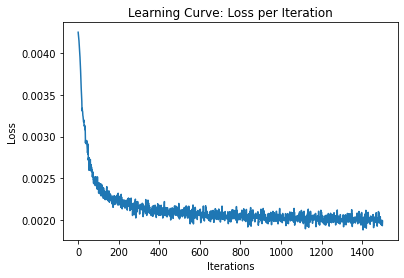

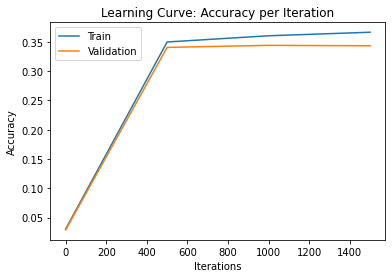

Hyperparameters that made it to more than 35% acc (train set):
Batch size = 1300
Learning rate = 0.002


In [17]:
pytorch_mlp = PyTorchMLP()
batch_size = 1300
learning_rate = 0.002
learning_curve_info = run_pytorch_gradient_descent(pytorch_mlp, train4grams, valid4grams,
                                                      batch_size = 1300, learning_rate = 0.002, weight_decay=0, max_iters = 1500,
                                                      checkpoint_path=None)

plot_learning_curve(*learning_curve_info)
print('Hyperparameters that made it to more than 35% acc (train set):')
print(f'Batch size = {batch_size}')
print(f'Learning rate = {learning_rate}')

### Part (c) -- 10%
**Write** a function `make_prediction` that takes as parameters
a PyTorchMLP model and sentence (a list of words), and produces
a prediction for the next word in the sentence.
 

In [18]:
def make_prediction_torch(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PYTorchMLP.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])
    """
    global vocab_stoi, vocab_itos
  
    #  Write your code here
    indices = convert_words_to_indices([sentence])
    oneHot = make_onehot(indices[0])
    oneHot = torch.Tensor(oneHot)
    predicted_tens = model.forward(oneHot)

    y = predicted_tens.detach().numpy() # convert the PyTorch tensor => numpy array
    pred = np.argmax(y, axis=1)
    predicted_indice = pred[0]
    predicted_word = vocab_itos[predicted_indice]
    return predicted_word


### Part (d) -- 10%

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense?

In many cases where you overfit the model can either output the same results for all inputs or just memorize the dataset. 

**Print** the output for all of these sentences and 
**Write** below if you encounter these effects or something else which indicates overfitting, if you do train again with better hyperparameters.




In [19]:
# Write your code here
lines = []
lines.append("You are a")
lines.append("few companies show")
lines.append("There are no")
lines.append("yesterday i was")
lines.append("the game had")
lines.append("yesterday the federal")

sentences = []
for line in lines:
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)
    print(sentence)
for i in range(0,np.shape(sentences)[0],1):
  pred = make_prediction_torch(pytorch_mlp, sentences[i])
  sentences[i].append(pred) # add the word to the sentence
print(f'\n')  
for i in range(0,np.shape(sentences)[0],1):
  print(sentences[i]) #print the whole sentence (last word is the output)



['you', 'are', 'a']
['few', 'companies', 'show']
['there', 'are', 'no']
['yesterday', 'i', 'was']
['the', 'game', 'had']
['yesterday', 'the', 'federal']


['you', 'are', 'a', 'good']
['few', 'companies', 'show', '.']
['there', 'are', 'no', 'other']
['yesterday', 'i', 'was', 'nt']
['the', 'game', 'had', 'to']
['yesterday', 'the', 'federal', 'government']


**Write your answers here:**

Most of the prediction actually do make sense.
none of the overfitting effect as described is seen, not in this small dataset nor the learning curve.
We conclude that the model is good enough.

### Part (e) -- 6%

Report the test accuracy of your model

In [20]:
# Write your code here

accuracy_test = estimate_accuracy_torch(pytorch_mlp,test4grams)
print(f'Accuracy of the model using the test dataset is {round(accuracy_test*100,2)}%')
#make_prediction_torch(pytorch_mlp, test4grams)


Accuracy of the model using the test dataset is 34.51%


## Question 3. Learning Word Embeddings (24 %)

In this section, we will build a slightly different model with a different
architecture. In particular, we will first compute a lower-dimensional
*representation* of the three words, before using a multi-layer perceptron.

Our model will look like this:

<img src="https://drive.google.com/uc?id=16lXygLTSuRgOCj6UWK0vHkSoyRJWfMSZ" />
 

This model has 3 layers instead of 2, but the first layer of the network
is **not** fully-connected. Instead, we compute the representations of each
of the three words **separately**. In addition, the first layer of the network
will not use any biases. The reason for this will be clear in question 4.
 

### Part (a) -- 10%

The PyTorch model is implemented for you. Use 
`run_pytorch_gradient_descent` to train
your PyTorch MLP model to obtain a training accuracy of at least 38%.
Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.


In [30]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)
        self.fc_layer1 = nn.Linear(emb_size * 3, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        self.emb_size = emb_size
    def forward(self, inp):
        embeddings = torch.relu(self.word_emb_layer(inp))
        embeddings = embeddings.reshape([-1, self.emb_size * 3])
        hidden = torch.relu(self.fc_layer1(embeddings))
        return self.fc_layer2(hidden)


Iter 0. [Val Acc 5%] [Train Acc 5%, Loss 5.514981]
Iter 500. [Val Acc 33%] [Train Acc 34%, Loss 2.895968]
Iter 1000. [Val Acc 35%] [Train Acc 36%, Loss 2.671944]
Iter 1500. [Val Acc 36%] [Train Acc 38%, Loss 2.565680]
Iter 2000. [Val Acc 37%] [Train Acc 38%, Loss 2.527689]


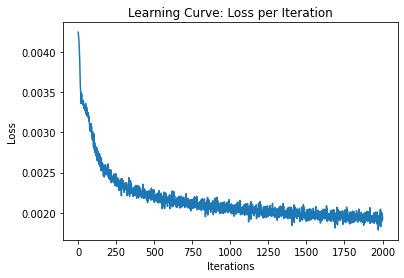

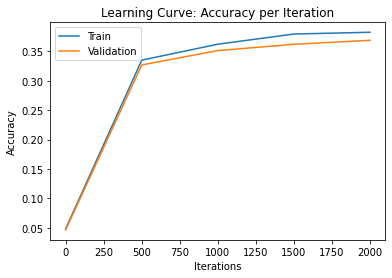

Hyperparameters that made it to more than 38% acc (train set):
Batch size = 1500
Learning rate = 0.0005


In [31]:
pytorch_wordemb= PyTorchWordEmb()

batch_size = 1500
learning_rate = 0.0005
learning_curve_info_2 = run_pytorch_gradient_descent(pytorch_wordemb, train4grams, valid4grams,
                                                      batch_size = 1300, learning_rate = 0.002, weight_decay=0, max_iters = 2000,
                                                      checkpoint_path=None)

plot_learning_curve(*learning_curve_info_2)
print('Hyperparameters that made it to more than 38% acc (train set):')
print(f'Batch size = {batch_size}')
print(f'Learning rate = {learning_rate}')

### Part (b) -- 10%

Use the function `make_prediction` that you wrote earlier to predict what the next word should be in each of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

How do these predictions compared to the previous model?

**Print** the output for all of these sentences using the new network and 
**Write** below how the new results compare to the previous ones.

Just like before, if you encounter overfitting,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%.

In [33]:
# Your code goes here

#using the "lines" argument from q2-d

sentences = []
for line in lines:
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)
    print(sentence)
for i in range(0,np.shape(sentences)[0],1):
  pred = make_prediction_torch(pytorch_wordemb, sentences[i])
  sentences[i].append(pred) # add the word to the sentence
print(f'\n')  
for i in range(0,np.shape(sentences)[0],1):
  print(sentences[i]) #print the whole sentence (last word is the output)


  

['you', 'are', 'a']
['few', 'companies', 'show']
['there', 'are', 'no']
['yesterday', 'i', 'was']
['the', 'game', 'had']
['yesterday', 'the', 'federal']


['you', 'are', 'a', 'good']
['few', 'companies', 'show', 'up']
['there', 'are', 'no', 'other']
['yesterday', 'i', 'was', 'going']
['the', 'game', 'had', 'to']
['yesterday', 'the', 'federal', 'government']


**Write your explanation here:**

we see that now we have better completion, after the word "show" we get an actual word and not "." although "." is the most common variable in our data.
  also we get the word "going" ater the "yesterday i was", what is a better sense completion than "nt".

### Part (c) -- 4%

Report the test accuracy of your model

In [34]:
# Write your code here

accuracy_test_2 = estimate_accuracy_torch(pytorch_wordemb,test4grams)
print(f'Accuracy of the model using the test dataset is {round(accuracy_test_2*100,2)}%')
#make_prediction_torch(pytorch_wordemb, test4grams)


Accuracy of the model using the test dataset is 37.25%


## Question 4. Visualizing Word Embeddings (14%)

While training the `PyTorchMLP`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings, which are a key concept in natural language processing.




Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".


### Part (a) -- 4%

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.

In [35]:
word_emb_weights = list(pytorch_wordemb.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T


**Write your explanation here:**

word_emb_layer, which takes a one-hot representation of a word in our vocabulary, and returns a low-dimensional vector representation of that word. it means that it get an input of vector of 249 zeros and 1 "one" that represent the index of the word. because each word represented with zeros exept the i'th index we can low the dimension of the vector without lossing data.

### Part (b) -- 5%

One interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the *cosine similarity* of
every pair of words in our vocabulary. This measure of similarity between vector ${\bf v}$ and ${\bf w}$ is defined as 
   $$d_{\rm cos}({\bf v},{\bf w}) = \frac{{\bf v}^T{\bf w}}{||{\bf v}|| ||{\bf w}||}.$$  We also pre-scale the vectors to have a unit norm, using Numpy's `norm` method.

In [36]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.0636967
-0.029274637


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [37]:
# Write your code here

def five_closest(word):
  similarity_list={}
  for i in vocab_stoi:
    similarity_list[i]=similarities[vocab_stoi[word], vocab_stoi[i]]
  similarity_list = dict(sorted(similarity_list.items(), key=lambda item: item[1]))
  return dict(list(similarity_list.items())[-6:-1])
  
print("four:")
print(five_closest("four"))
print("go:")
print(five_closest("go"))
print("what:")
print(five_closest("what"))
print("should:")
print(five_closest("should"))
print("school:")
print(five_closest("school"))
print("your:")
print(five_closest("your"))
print("yesterday:")
print(five_closest("yesterday"))
print("not:")
print(five_closest("not"))


four:
{'years': 0.3607498, 'some': 0.36348492, 'ago': 0.36358806, 'three': 0.41553098, 'many': 0.45719582}
go:
{'law': 0.38296777, 'new': 0.39452976, 'get': 0.40973827, 'going': 0.44577926, 'come': 0.49584293}
what:
{'which': 0.26556042, 'when': 0.32579932, 'where': 0.3491701, 'how': 0.36274096, 'who': 0.3695009}
should:
{'house': 0.34872577, 'may': 0.37461686, 'would': 0.4519977, 'might': 0.5095458, 'could': 0.62198937}
school:
{'white': 0.37193656, 'business': 0.37421435, 'good': 0.37800252, 'me': 0.4351621, 'last': 0.469771}
your:
{'the': 0.33883452, 'these': 0.38261515, 'political': 0.3838867, 'our': 0.47281218, 'its': 0.4887538}
yesterday:
{'day': 0.3598838, 'us': 0.37146613, 'week': 0.39852333, 'under': 0.41718796, 'ago': 0.44320312}
not:
{'director': 0.31440178, 'general': 0.3680016, 'never': 0.37976164, 'among': 0.38233173, 'nt': 0.42775065}


### Part (c) -- 5%

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment; we will cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.

Look at the plot and find at least two clusters of related words.

**Write** below for each cluster what is the commonality (if there is any) and if they make sense.

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.
Please make sure to submit your image in the PDF file.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


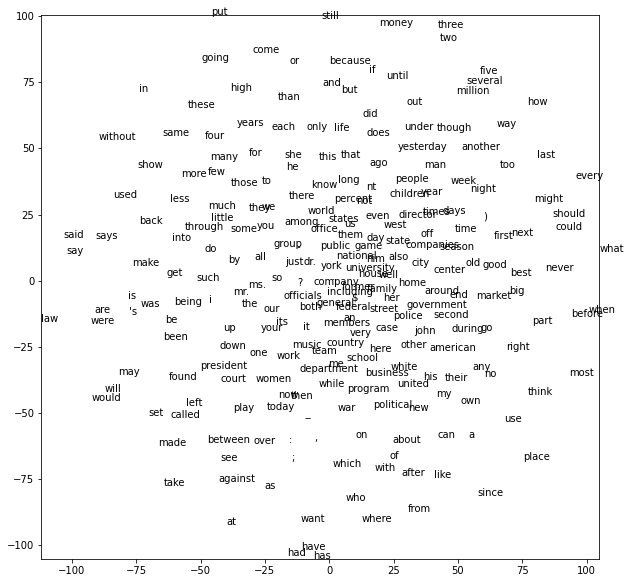

In [43]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()



**Explain and discuss your results here:**




cluster 1 (75:100,45:70) : (two,three,five,several,million) - A number or a way to describe quantity of something.

cluster 2 (:-100,-25:0) : (have, has , had) - three words with the same meaning.